## Pre-reqs

In [ ]:
#! pip3 install -U spacy
#! pip3 install -U spacy-lookups-data
#! python3 -m spacy download en_core_web_sm

In [ ]:
#! pip3 install nltk
#! pip3 install plotnine
#! pip3 install tomotopy

In [1]:
import nltk

nltk.download('stopwords', quiet=True)

True

## Load packages

In [26]:
import pandas as pd
from pandas import option_context
import numpy as np
import string
import re
import sys

# Tomotopy
import tomotopy as tp

# Spacy
import spacy

# Sklearn
from sklearn.datasets import fetch_20newsgroups

# Plotting
from pprint import pprint
from plotnine import ggplot, aes, geom_line, geom_histogram, labs, theme_bw, scale_x_continuous
import matplotlib.pyplot as plt

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.wrappers import LdaMallet

import pyLDAvis.gensim


### Prep stopwords

In [4]:
from nltk.corpus import stopwords
st_words = stopwords.words('english')
st_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Read abstract data

In [3]:
news = fetch_20newsgroups(subset='train')

In [5]:

news_df = pd.DataFrame([news.target, news.data]).T
news_df = news_df.set_index(0)

news_df = pd.concat([news_df, pd.Series(news.target_names)],axis=1, join="inner")
news_df.reset_index(inplace=True)
news_df.columns = ["topic_id", "content", "topic_name"]

news_df.head()

,topic_id,content,topic_name
0,7,From: lerxst@wam.umd.edu (where's my thing)\nS...,rec.autos
1,4,From: guykuo@carson.u.washington.edu (Guy Kuo)...,comp.sys.mac.hardware
2,4,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,comp.sys.mac.hardware
3,1,From: jgreen@amber (Joe Green)\nSubject: Re: W...,comp.graphics
4,14,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,sci.space


In [6]:
doc_list = news_df.content.values.tolist()

In [7]:
doc_list[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

### Removing @s, new lines and single quotes

In [8]:
# Remove Emails
doc_list = [re.sub(r'\S*@\S*\s?', '', sent) for sent in doc_list]

# Remove new line characters
doc_list = [re.sub(r'\s+', ' ', sent) for sent in doc_list]

# Remove distracting single quotes
doc_list = [re.sub(r"\'", "", sent) for sent in doc_list]


### Removing punctuations, lowercasing and splitting abstracts into lists

In [9]:
word_list = [gensim.utils.simple_preprocess(txt, deacc=True, min_len=3) for txt in doc_list]

In [10]:
word_list[0][:6]

['from', 'wheres', 'thing', 'subject', 'what', 'car']

### Bigram model to capture co-occurent words

In [11]:
bigram = Phrases(word_list, min_count=5, threshold=100)

bigram_model = Phraser(bigram)


### Remove standard and extended Stopwords

In [12]:
sentence = "A letter has been written asking him to be released"
for word in sentence.split():
    if word not in st_words:
        print("Kept ==> " +word)
    else:
        print("Removed: " +word)

Kept ==> A
Kept ==> letter
Removed: has
Removed: been
Kept ==> written
Kept ==> asking
Removed: him
Removed: to
Removed: be
Kept ==> released


In [13]:
word_list_nostops = [[word for word in txt if word not in st_words] for txt in word_list]

In [17]:
word_list_nostops[0][:7]

['wheres', 'thing', 'car', 'nntp', 'posting', 'host', 'rac']

### Create Bigrams

In [18]:
word_bigrams = [bigram_model[w_vec] for w_vec in word_list_nostops]

In [20]:
word_bigrams[0][:7]

['wheres', 'thing', 'car', 'nntp_posting', 'host', 'rac_wam', 'umd']

### Word Lemmatization

In [21]:
## Example
sentence = "A letter has been written asking him to be released"

spC = spacy.load('en_core_web_sm')

lemma_sentence = spC(sentence)
for token in lemma_sentence:
    print(token.text + " ==> " +token.lemma_ + ", " + token.pos_)

A ==> a, DET
letter ==> letter, NOUN
has ==> have, AUX
been ==> be, AUX
written ==> write, VERB
asking ==> ask, VERB
him ==> -PRON-, PRON
to ==> to, PART
be ==> be, AUX
released ==> release, VERB


In [22]:

spC = spacy.load('en_core_web_sm')
postags = ['NOUN','VERB', 'ADV', 'ADJ']


def lemmatize(word_list, ptags = postags ):
    '''Lemmatizes words based on allowed postags, input format is list of sublists 
       with strings'''
    
    lem_lists =[]
    for vec in word_list:
        sentence = spC(" ".join(vec))
        lem_lists.append([token.lemma_ for token in sentence if token.pos_ in ptags])
    
    return lem_lists


In [23]:

word_list_lemmatized = lemmatize(word_bigrams)


In [24]:
# Lemmatization in action
for i, j in zip(word_bigrams[0][:5], word_list_lemmatized[0][:5]):
    print(i + " ==> " + j )

wheres ==> where
thing ==> thing
car ==> car
nntp_posting ==> nntp_poste
host ==> host


### Tomotopy

In [317]:
from sklearn.model_selection import train_test_split

In [328]:
indices = np.arange(len(word_list_lemmatized))
train_set, test_set, train_idx, test_idx = train_test_split(word_list_lemmatized, indices,  test_size=0.2, random_state=1)

In [320]:
hdp = tp.HDPModel(tw=tp.TermWeight.IDF, min_cf=5,
                  rm_top=7, gamma=1, alpha=0.1, initial_k=10, seed=99999)

for vec in word_list_lemmatized:
    hdp.add_doc(vec)

In [364]:
hdp = tp.HDPModel(tw=tp.TermWeight.IDF, min_cf=10,
                  rm_top=7, gamma=1, alpha=0.1, initial_k=10, seed=99999)

In [365]:
for vec in train_set:
    hdp.add_doc(vec)

In [366]:
hdp.burn_in = 100
hdp.train(0)
print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
print('Removed top words:', hdp.removed_top_words)
print('Training...', file=sys.stderr, flush=True)

Training...


Num docs: 9051 , Vocab size: 6850 , Num words: 768269
Removed top words: ['line', 'would', 'write', 'say', 'know', 'article', 'people']


In [367]:
for i in range(0, 1000, 100):
    hdp.train(100, workers=3)
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))

Iteration: 0	Log-likelihood: -28.121250503037984	Num. of topics: 14
Iteration: 100	Log-likelihood: -28.114680163930686	Num. of topics: 14
Iteration: 200	Log-likelihood: -28.114330701922498	Num. of topics: 14
Iteration: 300	Log-likelihood: -28.11424202512098	Num. of topics: 14
Iteration: 400	Log-likelihood: -28.115250289374806	Num. of topics: 14
Iteration: 500	Log-likelihood: -28.111427594161693	Num. of topics: 15
Iteration: 600	Log-likelihood: -28.1117555238635	Num. of topics: 14
Iteration: 700	Log-likelihood: -28.111880854704747	Num. of topics: 14
Iteration: 800	Log-likelihood: -28.11056207379142	Num. of topics: 14
Iteration: 900	Log-likelihood: -28.111186114717214	Num. of topics: 14


In [369]:
important_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]
cnt=0
topic_list= []
for k in important_topics:
    if not hdp.is_live_topic(k): continue
    print('Topic #{}'.format(k))
    cnt+=1
    tmp =[]
    for word, prob in hdp.get_topic_words(k):
        print('\t', word, prob, sep='\t')
        tmp.append(word)
    
    topic_list.append(tmp)

Topic #0
		believe	0.0029054332990199327
		religion	0.002671332098543644
		think	0.0024655803572386503
		atheist	0.002413469599559903
		may	0.0022393891122192144
		many	0.0022024973295629025
		faith	0.0021962944883853197
		man	0.002190355444326997
		see	0.002165014622732997
		make	0.0021605300717055798
Topic #7
		gun	0.004300170112401247
		government	0.003760718507692218
		go	0.0027496840339154005
		right	0.0026529834140092134
		make	0.0026041867677122355
		law	0.0025736894458532333
		think	0.0025134331081062555
		s	0.002277219668030739
		kill	0.0021818014793097973
		state	0.0021662507206201553
Topic #5
		card	0.006398941855877638
		drive	0.006046635564416647
		scsi	0.005567584186792374
		window	0.00503903953358531
		system	0.004496137145906687
		driver	0.004463881719857454
		problem	0.004331712145358324
		use	0.003910976927727461
		monitor	0.003746643429622054
		disk	0.0036858583334833384
Topic #9
		file	0.007420816924422979
		key	0.007028989959508181
		server	0.005387996323406696
		i

In [377]:
doc_inst = hdp.make_doc(test_set[0])

In [378]:
topic_dist, ll = hdp.infer(doc_inst)

In [379]:
np.array(topic_dist).argmax()

2

In [381]:
news_df.iloc[test_idx[0],:].topic_name

'rec.motorcycles'

In [325]:
test_vocab = corpora.Dictionary(train_set)
test_corpus = [test_vocab.doc2bow(words) for words in train_set]

In [382]:
cm = CoherenceModel(topics=topic_list, corpus=test_corpus, dictionary=test_vocab, texts=train_set, 
                    coherence='c_v')

In [383]:
cm.get_coherence()

0.6065992825965966

### Modeling


In [235]:
# Create vocab dictionary, compact the vocabulary to about 11000 words
vocab = corpora.Dictionary(word_list_lemmatized)
vocab.filter_extremes(no_below=5, no_above=0.5)
vocab.compactify()

it = 0
for k,v in vocab.items():
    print(str(k) + ": "+ v) 
    it +=1
    if it == 10:
        break

0: addition
1: body
2: bring
3: call
4: car
5: could
6: day
7: door
8: early
9: engine


In [237]:
corpus = [vocab.doc2bow(words) for words in word_list_lemmatized]

In [238]:
len(vocab)

11254

In [239]:
len(corpus)

11314

In [240]:
[[(vocab[key], freq) for key, freq in doc] for doc in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('sport', 1),
  ('thank', 1),
  ('thing', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

In [31]:
from gensim.models import LdaModel

In [105]:
lda_not_mallet = LdaModel(corpus=corpus, id2word=vocab, num_topics=2)

In [106]:
clda = CoherenceModel(model=lda_not_mallet, dictionary=vocab, texts=word_list_lemmatized, coherence='c_v')
clda.get_coherence()

0.3073462673692767

In [119]:
lda_not_mallet[corpus[7]]

[(0, 0.9662923), (1, 0.03370771)]

In [120]:
lda_not_mallet.show_topic(0, topn=20)

[('would', 0.029727804),
 ('car', 0.027772374),
 ('may', 0.015006075),
 ('article', 0.01479867),
 ('get', 0.014543704),
 ('space', 0.013753302),
 ('make', 0.012164336),
 ('think', 0.011653439),
 ('year', 0.011387037),
 ('say', 0.010959833),
 ('know', 0.010458179),
 ('time', 0.010107627),
 ('good', 0.0098372465),
 ('go', 0.009629875),
 ('could', 0.009613588),
 ('also', 0.0092494),
 ('system', 0.008733391),
 ('much', 0.008417269),
 ('use', 0.008136761),
 ('first', 0.007881667)]

In [468]:
hdp0 = HdpModel(corpus=corpus, id2word=vocab, alpha=0.1,  gamma=1, T=20, K=8)
cm = CoherenceModel(model=hdp0, dictionary=vocab, texts=word_list_lemmatized, coherence='c_v')
cm.get_coherence()

0.579349871122813

0.20462505897911623

In [71]:
hdp0[corpus[9]]

[(0, 0.011398457873277217), (1, 0.9886015421267228)]

In [69]:
hdp0.show_topic(1)

[('include', 0.011732284330441671),
 ('sit', 0.008939937279261245),
 ('likely', 0.008321108301470629),
 ('end', 0.008032085943254153),
 ('auto', 0.00802295620058954),
 ('break', 0.007834643890047337),
 ('run', 0.007715152630154296),
 ('keep', 0.007336516770048001),
 ('article', 0.006970191383604304),
 ('rather', 0.006934336197686227),
 ('similar', 0.006801655901483267),
 ('owner', 0.006570800128752089),
 ('early', 0.006505415517180173),
 ('development', 0.006500571102041467),
 ('small', 0.0064590561303098214),
 ('around', 0.006310180993571985),
 ('change', 0.006288244779010798),
 ('learn', 0.0059940870563033625),
 ('self', 0.0059427472521371314),
 ('truck', 0.005936812818376073)]

In [465]:
py_corpus = [x for x in corpus if len(x) > 0]

In [469]:
prep= pyLDAvis.gensim.prepare(hdp0, py_corpus, vocab)
pyLDAvis.display(prep)


0.5772121246135256

In [745]:
hdp0.lda_alpha

array([0.04308227, 0.03457465, 0.00588713, 0.00139719, 0.00139242,
       0.00140047, 0.00107401, 0.00112853, 0.0009715 , 0.00090148,
       0.00089521, 0.00112445, 0.00092571, 0.00071058, 0.00076691,
       0.00072714, 0.00074787, 0.00075055, 0.00084882, 0.00069311])

In [765]:
0.04308227/0.00588713

7.318042917346823

In [823]:
hdp0.lda_alpha[0] / hdp0.lda_alpha[2]

28.88810489446619

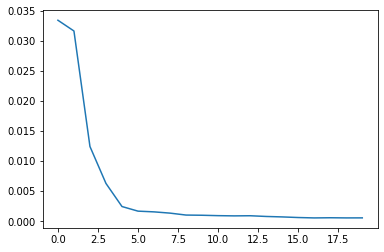

In [803]:
plt.plot(hdp0.lda_alpha)

In [235]:
hdp1 = HdpModel(corpus=corpus, id2word=vocab,alpha=0.1, gamma=1, T=150, K=8, chunksize=100, kappa=0.7, random_state=20)

In [236]:
hdp2 = HdpModel(corpus=corpus, id2word=vocab, alpha=0.1, gamma=1, T=350, K=8, chunksize=100, kappa=0.8, random_state=20)

In [ ]:
topic_info = hdp0.print_topics(num_topics=20)

### SANITY CHECKS

In [820]:
hdp0[corpus[9]]

[(0, 0.9986716552942675)]

In [829]:
from wordcloud import WordCloud

In [837]:
dict(hdp0.show_topic(0))

{'people': 0.008651010148616465,
 'article': 0.008271872595382859,
 'time': 0.006647194564747612,
 'good': 0.0060194334075500235,
 'system': 0.0049181439594451265,
 'year': 0.00474702697323882,
 'thing': 0.00458503464129745,
 'problem': 0.004170014843185883,
 'many': 0.004151126718903071,
 'host': 0.0038422752023128913,
 'organization': 0.0037475015832052873,
 'way': 0.0036240219250101087,
 'file': 0.003467648108722479,
 'question': 0.0033536377784454366,
 'new': 0.0033150541184389626,
 'program': 0.003115232574769458,
 'right': 0.00306570647358993,
 'number': 0.0028649323928630187,
 'point': 0.002819607616063096,
 'window': 0.0027439518055468893}

In [861]:
#for t in range(20):
#    plt.figure()
#    plt.imshow(WordCloud(background_color='white').fit_words(dict(hdp0.show_topic(t))))
#    plt.axis("off")
#    plt.title("Topic #" + str(t))
#    plt.show()

In [824]:
hdp0.show_topic(1)

[('article', 0.0015023591918481957),
 ('thing', 0.0011415265040784),
 ('true', 0.0010267792904915674),
 ('argument', 0.001003059405175015),
 ('people', 0.0009956434040023544),
 ('host', 0.0009642426815439876),
 ('car', 0.0009096803993349177),
 ('sure', 0.0009084376314981036),
 ('year', 0.0009050090509306608),
 ('many', 0.0008941289680427513),
 ('example', 0.0008510347594509191),
 ('good', 0.0008188344820505244),
 ('facility', 0.0008181364220688388),
 ('wrapper', 0.0008054187636716236),
 ('podein', 0.0007947583231067742),
 ('time', 0.0007272838470487488),
 ('organization', 0.0007165872752398088),
 ('sequent', 0.0006882349875407956),
 ('structured', 0.0006812483567647996),
 ('nature', 0.0006791348770595878)]

In [654]:
hdp0.m_var_sticks

array([[31239.99710122,  5232.55761048,  1544.72754684,   909.13695679,
          800.77547481,  1002.44126763,   896.11121122,   768.52045221,
          792.71744506,   646.65646797,   509.62249955,   641.40025302,
          483.54994264,   507.91205438,   459.18241554,   663.34991416,
          403.8892138 ,   619.96142661,   549.46151424],
       [17862.60785117, 12631.05024068, 11087.32269384, 10179.18573705,
         9379.41026224,  8377.96899461,  7482.85778339,  6715.33733118,
         5923.61988611,  5277.96341814,  4769.34091859,  4128.94066557,
         3646.39072293,  3139.47866855,  2681.29625301,  2018.94633885,
         1616.05712504,   997.09569843,   448.63418419]])

In [387]:
news_df.topic

,topic_id,content,topic_name
0,7,From: lerxst@wam.umd.edu (where's my thing)\nS...,rec.autos
1,4,From: guykuo@carson.u.washington.edu (Guy Kuo)...,comp.sys.mac.hardware
2,4,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,comp.sys.mac.hardware
3,1,From: jgreen@amber (Joe Green)\nSubject: Re: W...,comp.graphics
4,14,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,sci.space
5,16,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,talk.politics.guns
6,13,From: bmdelane@quads.uchicago.edu (brian manni...,sci.med
7,3,From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...,comp.sys.ibm.pc.hardware
8,2,From: holmes7000@iscsvax.uni.edu\nSubject: WIn...,comp.os.ms-windows.misc
9,4,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...,comp.sys.mac.hardware


In [619]:
hdp0.show_topic(2)

[('article', 0.0013179163450865502),
 ('wood_stove', 0.001135182492950929),
 ('thing', 0.001086118319931774),
 ('eavesdropping', 0.0008919078193118556),
 ('brutality', 0.0008692922997744474),
 ('wrap', 0.0008593717160128941),
 ('biochemistry', 0.0008473132553888815),
 ('weakling', 0.0008237121765479491),
 ('configure', 0.0008080060151357657),
 ('book', 0.0007786429728276201),
 ('egress', 0.0007532214939672576),
 ('people', 0.0007489291263493785),
 ('defence', 0.0007351214599643481),
 ('turkish_minority', 0.0007334206309015805),
 ('irvine', 0.0007278371840266935),
 ('floppy', 0.000714582900549028),
 ('director', 0.0007116625864314346),
 ('host', 0.0006880371141334753),
 ('way', 0.00068798648867575),
 ('allergic', 0.0006742179459968427)]

In [781]:
alpha0, beta0 = hdp0.hdp_to_lda()

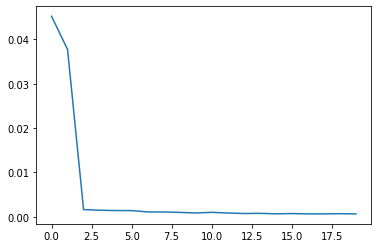

In [782]:
plt.plot(range(20),alpha0)
pass

In [256]:
alpha, beta = hdp1.hdp_to_lda()

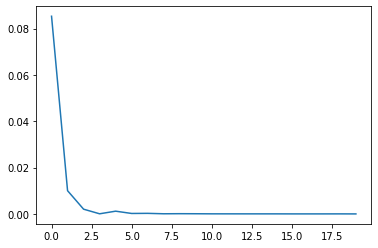

In [257]:
plt.plot(range(20),alpha[:20])
pass

In [258]:
alpha2, beta2 = hdp2.hdp_to_lda()

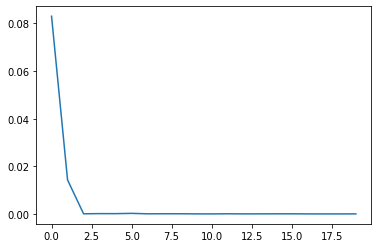

In [259]:
plt.plot(range(20),alpha2[:20])
pass

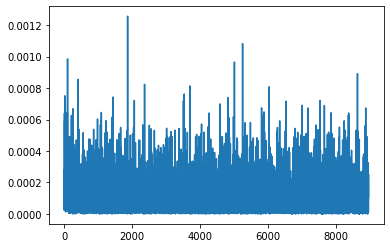

In [644]:
#plt.plot(list(range(20)),beta[:,0])
plt.plot(range(len(vocab)),beta0[17,:])
pass

### Model Evaluation - Coherence

In [74]:
models = [hdp0, hdp1, hdp2]
hdp_coherence_vals = []

for m in models:
    cm = CoherenceModel(model=m, dictionary=vocab, texts=word_list_lemmatized, coherence='c_v')
    hdp_coherence_vals.append(cm.get_coherence())


In [169]:
for i in range(len(models)):
    print("HDP Model " + str(i) + " Coherence score: " + str(hdp_coherence_vals[i]))

HDP Model 0 Coherence score: 0.41402400063088507
HDP Model 1 Coherence score: 0.4596102136731104
HDP Model 2 Coherence score: 0.5565876982176636


### Model Comparison

In [ ]:
#! curl -O http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#! unzip mallet-2.0.8.zip
#! rm mallet-2.0.8.zip

In [35]:
mallet_path = "mallet-2.0.8/bin/mallet"

In [36]:
def lda_coherence_vals(corpus, vocab, txt, stop, start=2, step_size=6):
    '''Computes LDA coherences values for a given range of topics'''
    
    c_scores = []

    for n_topic in range(start, stop, step_size):
        lda = LdaMallet(mallet_path, corpus=corpus, id2word=vocab, num_topics=n_topic)
        coherence_lda = CoherenceModel(model=lda, dictionary=vocab, texts=txt, coherence='c_v')
        c_scores.append(coherence_lda.get_coherence())
        
    return c_scores
    

In [166]:
steps = 6
stop = 26
coherence_vals = lda_coherence_vals(corpus, vocab, word_list_lemmatized, 
                                    stop=40, start=2, step_size=steps )


In [587]:
best_lda = LdaMallet(mallet_path, corpus=corpus, id2word=vocab, num_topics=20)
cmallet = CoherenceModel(model=best_lda, dictionary=vocab, texts=word_list_lemmatized, coherence='c_v')
cmallet.get_coherence()

0.5698721197557204

/usr/local/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 3 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


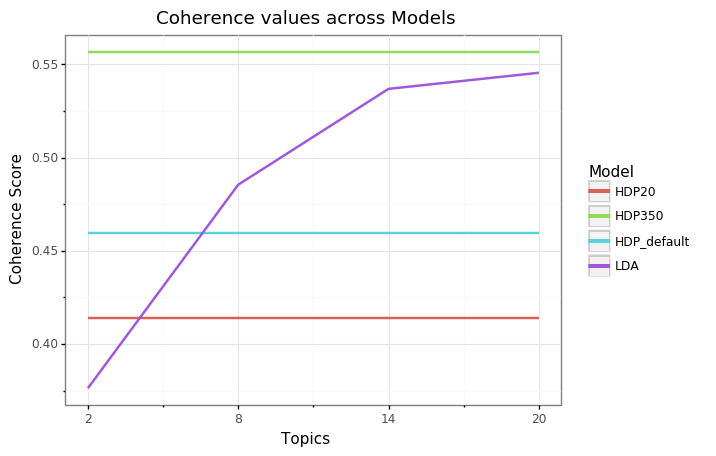

<ggplot: (367977333)>

In [167]:

topics = list(range(2,stop,steps))

df = pd.DataFrame([topics, coherence_vals]).T
for v in hdp_coherence_vals:
    vals = pd.Series(np.repeat(v, len(topics)))
    df = pd.concat([df, vals], axis=1)

df.columns = ["topics", "LDA", "HDP20", "HDP_default", "HDP350"]
df_melt = df.melt(id_vars=["topics"], var_name="Model")

(ggplot(df_melt, aes(x='topics', y='value', color='Model')) +
 geom_line(size=1) +
 labs(x = 'Topics', y="Coherence Score", title="Coherence values across Models")+
 theme_bw() +
 scale_x_continuous(breaks = topics)
)


In [77]:
cnts = np.zeros(len(corpus), dtype=int)
for i, cp in enumerate(corpus):
    cnts[i] = len(hdp2[cp])

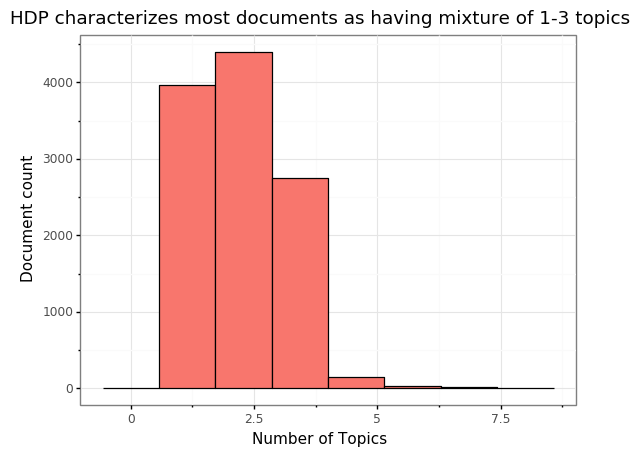

<ggplot: (365926281)>

In [98]:
df_cnts = pd.DataFrame(cnts, columns=["num_topics"])

(ggplot(df_cnts, aes('num_topics')) +
 geom_histogram(fill='#F8766D', color='black', bins=8 ) +
 labs(x='Number of Topics', y="Document count", 
      title="HDP characterizes most documents as having mixture of 1-3 topics") +
 theme_bw()
)

### Topic importance

In [99]:
# The corpus as index in the model provides us with the (topic_id, proportion) tuple
# for a specific document
hdp2[corpus[0]]

[(3, 0.3104252450183565), (6, 0.26490325356754646), (9, 0.42237553825062374)]

In [100]:
# We can obtain all the topic key words related to a topic this way
hdp2.show_topic(topic_id=9)

[('thank', 0.00887603530673754),
 ('host', 0.008264678406600732),
 ('need', 0.00694089001301371),
 ('be', 0.006925108376371276),
 ('would', 0.0067389652358371185),
 ('mail', 0.005964637334251539),
 ('organization', 0.005563916085396642),
 ('use', 0.005440828156119138),
 ('phone', 0.005359562090845406),
 ('know', 0.004582300074565976),
 ('work', 0.004354385168906362),
 ('go', 0.004054810729006758),
 ('product', 0.003988054349554451),
 ('information', 0.003940811545411079),
 ('file', 0.003902000892619754),
 ('program', 0.003875884452016117),
 ('also', 0.003652000329662418),
 ('nntp_poste', 0.0036181500074814205),
 ('datum', 0.0035833289763548973),
 ('cheap', 0.0034168193210301553)]

In [80]:
def topic_importance(model, corpus, txt):
    ''''''
    out_df = pd.DataFrame()
    
    for i, row in enumerate(model[corpus]):
        sort_row = sorted(row, key=lambda x: (x[1]), reverse=True) # sort based on proportion
        
        for k, (topic, proportion) in enumerate(sort_row):
            if k == 0:
                word_prop = model.show_topic(topic)
                k_words = ", ".join([w for w, p in word_prop])
                out_df = out_df.append(pd.Series([int(topic), round(proportion,6), k_words]), ignore_index=True)
            else:
                break
    
    original_docs = pd.Series(txt)
    out_df = pd.concat([out_df, original_docs], axis=1)
    
    return out_df
                

In [101]:
top_k = topic_importance(hdp2, corpus, doc_list)

In [ ]:
top_dominant = top_k.reset_index()
top_dominant.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

with option_context('display.max_colwidth', 100):
    display(top_dominant.head(8))

### Document importance  topics

In [ ]:
top_doc_per_topic = pd.DataFrame()

top_k.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']

top_k_grp = top_k.groupby('Dominant_Topic')

for i, grp in top_k_grp:
    top_doc_per_topic= pd.concat([top_doc_per_topic , 
                                     grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], axis=0)

# Reset Index    
top_doc_per_topic.reset_index(drop=True, inplace=True)

# Format
top_doc_per_topic.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
with option_context('display.max_colwidth', 100):
    display(top_doc_per_topic.head(8))

### Topic distribution across topics

In [ ]:
# Number of Documents for Each Topic
topic_cnts = top_k['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_cnts/topic_cnts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = top_k[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().set_index("Dominant_Topic")

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_cnts, topic_contribution], axis=1)


# Change Column names
df_dominant_topics.reset_index(inplace=True)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']


# Show
with option_context('display.max_colwidth', 100):
    display(df_dominant_topics.head(10))


In [ ]:
with option_context('display.max_colwidth', 200):
    display(df_dominant_topics.sort_values(by="Perc_Documents", ascending=False).head(30))